<a href="https://colab.research.google.com/github/JanLeyva/DeepLearning/blob/main/Copia_de_Assignment3Test7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!python --version

Python 3.7.12


# Assignment 3: Attention

The objectives of this assignment are:

+ To implement Bahdanau Attention and Luong General Attention classes.
+ To do a comparative (# of steps to converge, test error) of the three methods we have seen. Use these values for the comparative (the training datset size and `rnn_units` and `batch_size` values are up to you): 
    + `n_timesteps_in = 100`
    + `n_features = 20`.   
+ To implement a function to visualize the attention weights for one example. You can visualize them as in this figure (that corresponds to a machine translation task):

<div>
<center>
<img src="https://jalammar.github.io/images/attention_sentence.png" width="200">
</center>
</div>

+ To write a blog entry explaining in your words how does attention work. You can do it in your favourite blog site. If you do not have a favourite blog site, you can start one here: https://hackmd.io/

You have to report all your work at the end of this notebook.



# Code

In [3]:
#@title Some utils
from random import randint
import random
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

random.seed(12345678)


def generate_sequence(length, n_unique):
    """
    Generate a sequence of random integers.
    
    :length: Total length of the generated sequence
    :n_unique: Maximum number allowed
    """
    return [randint(1, n_unique-1) for _ in range(length)]

def one_hot_encode(sequence, n_unique):
    """
    Transform a sequence of integers into a one-hot-encoding vector
    
    :sequence: The sequence we want to transform
    :n_unique: Maximum number allowed (length of the one-hot-encoded vector)
    """
    encoding = list()
    for value in sequence:
        vector = [0 for _ in range(n_unique)]
        vector[value] = 1
        encoding.append(vector)
    return np.array(encoding)

def one_hot_decode(encoded_seq):
    """
    Transorm a one-hot-encoded vector into a list of integers
    
    :encoded_seq: One hot encoded sequence to be transformed
    """
    return [np.argmax(vector) for vector in encoded_seq]


def get_reversed_pairs(time_steps,vocabulary_size):
    """
    Generate a pair X, y where y is the 'reversed' version of X.
    
    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """
    # generate random sequence and reverse it
    sequence_in = generate_sequence(time_steps, vocabulary_size)
    sequence_out = sequence_in[::-1]

    # one hot encode both sequences
    X = one_hot_encode(sequence_in, vocabulary_size)
    y = one_hot_encode(sequence_out, vocabulary_size)
    
    # reshape as 3D so it can be inputed to the LSTM
    X = X.reshape((1, X.shape[0], X.shape[1]))
    y = y.reshape((1, y.shape[0], y.shape[1]))
    return X,y


def create_dataset(train_size, test_size, time_steps,vocabulary_size):
    """
    Generates a datset of reversed pairs X, y.
    
    :train_size: Number of train pairs
    :test_size: Number of test pairs
    :time_steps: Sequence length
    :vocabulary_size: Maximum number allowed
    """
    
    # Generate reversed pairs for training
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(train_size)]
    pairs= np.array(pairs).squeeze()
    X_train = pairs[:,0]
    y_train = pairs[:,1]
    
    # Generate reversed pairs for test
    pairs = [get_reversed_pairs(time_steps,vocabulary_size) for _ in range(test_size)]
    pairs= np.array(pairs).squeeze()
    X_test = pairs[:,0]
    y_test = pairs[:,1]	

    return X_train, y_train, X_test, y_test


def train_test(model, X_train, y_train , X_test, y_test, epochs=500, batch_size=32, patience=5):
    """
    It trains a model and evaluates the result on the test dataset
    
    :model: Model to be fit
    :X_train, y_train: Train samples and labels 
    :X_test y_test: Test samples and labels 
    :epochs: Maximum number of iterations that the model will perform
    :batch_size: Samples per batch
    :patience: Number of rounds without improvement that the model can perform. If there is no improvement on the loss, it will stop the trainning process.
    """
    
    # Train the model
    history=model.fit(X_train, y_train, 
                      validation_split= 0.1, 
                      epochs=epochs,
                      batch_size=batch_size, 
                      callbacks=[EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)])
    
    _, train_acc = model.evaluate(X_train, y_train, batch_size=batch_size)
    _, test_acc = model.evaluate(X_test, y_test, batch_size=batch_size)
    
    print('\nPREDICTION ACCURACY (%):')
    print('Train: %.3f, Test: %.3f' % (train_acc*100, test_acc*100))
    
    fig, axs = plt.subplots(1,2, figsize=(12,5))
    # summarize history for loss
    axs[0].plot(history.history['loss'])
    axs[0].plot(history.history['val_loss'])
    axs[0].set_title(model.name+' loss')
    axs[0].set_ylabel('loss')
    axs[0].set_xlabel('epoch')
    axs[0].legend(['train', 'val'], loc='upper left')
    
    # summarize history for accuracy
    axs[1].plot(history.history['accuracy'])
    axs[1].plot(history.history['val_accuracy'])
    axs[1].set_title(model.name+' accuracy')
    axs[1].set_ylabel('accuracy')
    axs[1].set_xlabel('epoch')
    axs[1].legend(['train', 'val'], loc='upper left')
    plt.show()
    
    
def predict(model, n_timesteps_in,n_features, x, y_real=None, batch_size = 1):
    pred=model.predict(x.reshape(1,n_timesteps_in,n_features), batch_size= batch_size)
    print('input', one_hot_decode(x))    
    print('predicted', one_hot_decode(pred[0]))
    if y_real is not None:
        print('expected', one_hot_decode(y_real))

In [4]:
# @title build_attention_model function <- to delet

import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

tf.keras.backend.set_floatx('float64')

#attention model
def build_attention_model(attention, batch_size, rnn_units):
    
    # ENCODER STEP
    # ------------
    # Same encoder as before with one and only difference. Now we need all the lstm states so we
    # set return_sequences=True and return_state=True.
    encoder_inputs = Input(shape=(n_timesteps_in, n_features), name='encoder_inputs')
    encoder_lstm = LSTM(rnn_units, return_sequences=True, return_state=True, name='encoder_lstm')
    encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
    
    states = [encoder_state_h, encoder_state_c]
    
    # DECODER STEP
    # ------------
    # Set up the decoder layers
    # input shape: (1, n_features + rnn_units)
    decoder_lstm = LSTM(rnn_units, return_state=True, name='decoder_lstm')
    decoder_dense = Dense(n_features, activation='softmax', name='decoder_dense')
    
    # As before, we use as first input the 0-sequence
    all_outputs = []
    inputs = np.zeros((batch_size, 1, n_features))
    
    # Decoder_outputs is the last hidden state of the encoder. Encoder_outputs are all the states
    decoder_outputs = encoder_state_h
    
    # Decoder will only process one time step at a time.
    for _ in range(n_timesteps_in):

        # Pay attention!
        # decoder_outputs (last hidden state) + encoder_outputs (all hidden states)
        context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
        context_vector = tf.expand_dims(context_vector, 1)

        # create the context vector by applying attention to 
        # Concatenate the input + context vectore to find the next decoder's input
        inputs = tf.concat([context_vector, inputs], axis=-1)

        # Passing the concatenated vector to the LSTM
        # Run the decoder on one timestep with attended input and previous states
        decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)        
        outputs = decoder_dense(decoder_outputs)
        
        # Use the last hidden state for prediction the output
        # save the current prediction
        # we will concatenate all predictions later
        outputs = tf.expand_dims(outputs, 1)
        all_outputs.append(outputs)
        
        # Reinject the output (prediction) as inputs for the next loop iteration
        # as well as update the states
        inputs = outputs
        states = [state_h, state_c]
        
    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model, encoder_lstm, decoder_lstm, decoder_dense

In [5]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

tf.keras.backend.set_floatx('float64')

#attention model
def build_attention_model(attention, batch_size, rnn_units):
    
    # ENCODER STEP
    # ------------
    # Same encoder as before with one and only difference. Now we need all the lstm states so we
    # set return_sequences=True and return_state=True.
    encoder_inputs = Input(shape=(n_timesteps_in, n_features), name='encoder_inputs')
    encoder_lstm = LSTM(rnn_units, return_sequences=True, return_state=True, name='encoder_lstm')
    encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
    
    states = [encoder_state_h, encoder_state_c]
    
    # DECODER STEP
    # ------------
    # Set up the decoder layers
    # input shape: (1, n_features + rnn_units)
    decoder_lstm = LSTM(rnn_units, return_state=True, name='decoder_lstm')
    decoder_dense = Dense(n_features, activation='softmax', name='decoder_dense')
    
    # As before, we use as first input the 0-sequence
    all_outputs = []
    inputs = np.zeros((batch_size, 1, n_features))
    
    # Decoder_outputs is the last hidden state of the encoder. Encoder_outputs are all the states
    decoder_outputs = encoder_state_h
    
    # Decoder will only process one time step at a time.
    for _ in range(n_timesteps_in):

        # Pay attention!
        # decoder_outputs (last hidden state) + encoder_outputs (all hidden states)
        context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
        context_vector = tf.expand_dims(context_vector, 1)

        # create the context vector by applying attention to 
        # Concatenate the input + context vectore to find the next decoder's input
        inputs = tf.concat([context_vector, inputs], axis=-1)

        # Passing the concatenated vector to the LSTM
        # Run the decoder on one timestep with attended input and previous states
        decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)        
        outputs = decoder_dense(decoder_outputs)
        
        # Use the last hidden state for prediction the output
        # save the current prediction
        # we will concatenate all predictions later
        outputs = tf.expand_dims(outputs, 1)
        all_outputs.append(outputs)
        
        # Reinject the output (prediction) as inputs for the next loop iteration
        # as well as update the states
        inputs = outputs
        states = [state_h, state_c]
        
    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

## LuongDotAttention

Luong Dot Attention score is defined by:

$$score(h_t,\hat{h}_s)= h_t^T \hat{h}_s$$


This function was presentated in the paper [Effective Approaches to Attention-based Neural Machine Translation, 2015](https://arxiv.org/abs/1508.04025). In this paper they present the Dot Luong Attention and the General Luong. Notice that this attention function don't have training paramaters.



In [20]:
class LuongDotAttention(tf.keras.layers.Layer):
    def __init__(self):
        super(LuongDotAttention, self).__init__()

    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])

        # LUONGH Dot-product
        score = tf.transpose(tf.matmul(query_with_time_axis, 
                                       values_transposed), perm=[0, 2, 1])

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

### Defining parameters

In [29]:
# Assignment parameters
# dataset 
n_timesteps_in = 100  # Sequence length
n_features = 20     # Maximum number allowed-1 (length of the one-hot-encoded vector)
train_sizeA = 2000 
test_sizeA = 200
X_trainA, y_trainA, X_testA, y_testA = create_dataset(train_sizeA, test_sizeA, n_timesteps_in, n_features )

# training parameters
batch_sizeA = 100

# model parameters
rnn_unitsA = 100

In [6]:
# dataset 
n_timesteps_in = 100  # Sequence length
n_features = 20     # Maximum number allowed-1 (length of the one-hot-encoded vector)
train_size = 2000 
test_size = 200
X_train, y_train, X_test, y_test = create_dataset(train_size, test_size, n_timesteps_in,n_features )

# training parameters
batch_size = 100

# model parameters
rnn_units = 100

## Attention model - Luong Dot

In [ ]:
# attention model
attentionA = LuongDotAttention()
model_attentionA, encoder_lstm, decoder_lstm, decoder_dense  = build_attention_model(attentionA, batch_sizeA, rnn_unitsA) 
# we need this encoder/decoder for the weight representation

In [22]:
# attention model
attention = LuongDotAttention()
model_attention = build_attention_model(attention, batch_size, rnn_units) 
# we need this encoder/decoder for the weight representation

### Training model

Epoch 1/50
18/18 [==============================] - 213s 3s/step - loss: 2.9633 - accuracy: 0.0556 - val_loss: 2.9467 - val_accuracy: 0.0539
Epoch 2/50
18/18 [==============================] - 12s 688ms/step - loss: 2.9447 - accuracy: 0.0553 - val_loss: 2.9434 - val_accuracy: 0.0553
Epoch 3/50
18/18 [==============================] - 12s 674ms/step - loss: 2.9417 - accuracy: 0.0614 - val_loss: 2.9399 - val_accuracy: 0.0677
Epoch 4/50
18/18 [==============================] - 12s 688ms/step - loss: 2.9354 - accuracy: 0.0695 - val_loss: 2.9320 - val_accuracy: 0.0698
Epoch 5/50
18/18 [==============================] - 12s 676ms/step - loss: 2.9253 - accuracy: 0.0769 - val_loss: 2.9188 - val_accuracy: 0.0800
Epoch 6/50
18/18 [==============================] - 12s 678ms/step - loss: 2.9135 - accuracy: 0.0828 - val_loss: 2.9157 - val_accuracy: 0.0796
Epoch 7/50
18/18 [==============================] - 12s 690ms/step - loss: 2.9059 - accuracy: 0.0868 - val_loss: 2.9031 - val_accuracy: 0.0890
E

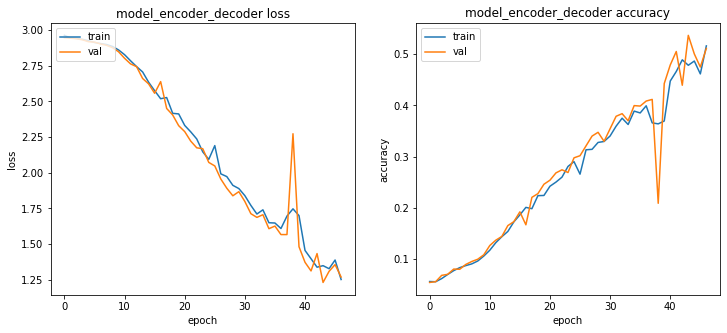

In [23]:
# Assignment paramenters
train_test(model_attention, X_train, y_train , X_test,
           y_test, batch_size=batch_size,epochs=50, patience=3)

Epoch 1/50
18/18 [==============================] - 217s 3s/step - loss: 2.9662 - accuracy: 0.0533 - val_loss: 2.9485 - val_accuracy: 0.0594
Epoch 2/50
18/18 [==============================] - 12s 672ms/step - loss: 2.9449 - accuracy: 0.0573 - val_loss: 2.9429 - val_accuracy: 0.0524
Epoch 3/50
18/18 [==============================] - 12s 672ms/step - loss: 2.9403 - accuracy: 0.0635 - val_loss: 2.9384 - val_accuracy: 0.0638
Epoch 4/50
18/18 [==============================] - 12s 685ms/step - loss: 2.9328 - accuracy: 0.0698 - val_loss: 2.9306 - val_accuracy: 0.0701
Epoch 5/50
18/18 [==============================] - 12s 672ms/step - loss: 2.9244 - accuracy: 0.0763 - val_loss: 2.9218 - val_accuracy: 0.0776
Epoch 6/50
18/18 [==============================] - 12s 686ms/step - loss: 2.9168 - accuracy: 0.0807 - val_loss: 2.9161 - val_accuracy: 0.0798
Epoch 7/50
18/18 [==============================] - 12s 671ms/step - loss: 2.9084 - accuracy: 0.0852 - val_loss: 2.9051 - val_accuracy: 0.0848
E

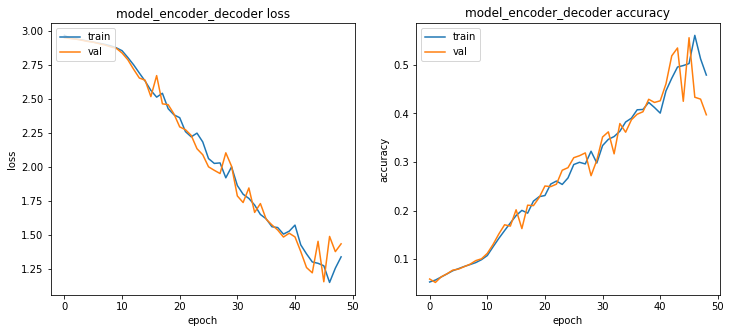

In [39]:
# Assignment paramenters
train_test(model_attention, X_train, y_train , X_test,
           y_test, batch_size=batch_size,epochs=50, patience=3)

# Bahdanau Attention

Bahdanau attention function is defined by:

$$ score(h_t, \hat{h}_s)=V^Ttanh(W_a[h_t:\hat{h}_s])$$

This function was presented on the paper [Neural Machine Translation by Jointly Learning to Align and Translate, 2014](https://arxiv.org/abs/1409.0473). This paper introduced and refined a technique called
“Attention”. The function include 2 trainable weight matrix ($W_{a1}, W_{a2}$), $V$ is a weight vector and $tanh$ to scale numbers [-1,1].

In [8]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):

    query_with_time_axis = tf.expand_dims(query, 1)

    score = self.V(tf.nn.tanh(self.W1(query_with_time_axis) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values

    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

# with assignment parameters

In [9]:
# attention model
attentionBahdanauAttentionA = BahdanauAttention(100)
model_attentionBahdanauAttentionA, encoder_lstmBah, decoder_lstmBah, decoder_denseBah = build_attention_model(attentionBahdanauAttentionA, batch_sizeA, rnn_unitsA)

NameError: ignored

In [17]:
# attention model
attentionBahdanauAttention = BahdanauAttention(100)
model_attentionBahdanauAttention = build_attention_model(attentionBahdanauAttention, batch_size, rnn_units)

Epoch 1/50
18/18 [==============================] - 297s 4s/step - loss: 2.9642 - accuracy: 0.0522 - val_loss: 2.9466 - val_accuracy: 0.0537
Epoch 2/50
18/18 [==============================] - 14s 786ms/step - loss: 2.9450 - accuracy: 0.0578 - val_loss: 2.9442 - val_accuracy: 0.0532
Epoch 3/50
18/18 [==============================] - 14s 765ms/step - loss: 2.9400 - accuracy: 0.0627 - val_loss: 2.9388 - val_accuracy: 0.0664
Epoch 4/50
18/18 [==============================] - 14s 777ms/step - loss: 2.9327 - accuracy: 0.0710 - val_loss: 2.9306 - val_accuracy: 0.0717
Epoch 5/50
18/18 [==============================] - 14s 766ms/step - loss: 2.9253 - accuracy: 0.0747 - val_loss: 2.9233 - val_accuracy: 0.0789
Epoch 6/50
18/18 [==============================] - 14s 776ms/step - loss: 2.9195 - accuracy: 0.0794 - val_loss: 2.9167 - val_accuracy: 0.0791
Epoch 7/50
18/18 [==============================] - 14s 765ms/step - loss: 2.9125 - accuracy: 0.0832 - val_loss: 2.9084 - val_accuracy: 0.0819
E

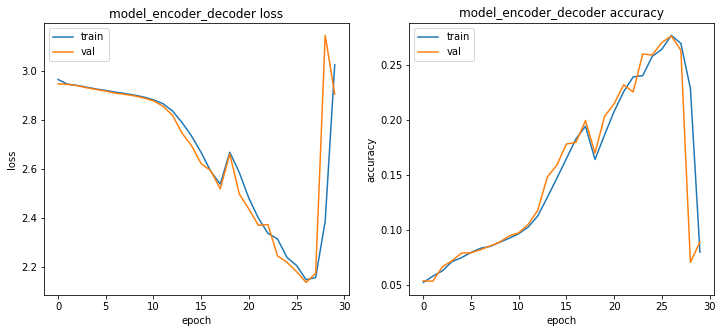

In [18]:
train_test(model_attentionBahdanauAttention, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=50, patience=3)

In [16]:
train_test(model_attentionBahdanauAttentionA, X_trainA, y_trainA , X_testA,
           y_testA, batch_size=batch_sizeA,epochs=50, patience=3)

NameError: ignored

# LuongGeneralAttention

Luong General Attention function is defined by:

$$score(h_t,\hat{h}_s)= h_t^T W_a\hat{h}_s$$

This function was presentated in the paper [Effective Approaches to Attention-based Neural Machine Translation, 2015](https://arxiv.org/abs/1508.04025). In this paper they present the Dot Luong Attention and the General Luong. The Luong general got a $W_a$ to be trained in order to get better performance.

In [13]:
class LuongGeneralAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LuongGeneralAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)


    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])

        # LUONGH Dot-product
        score = tf.transpose(tf.matmul(query_with_time_axis, 
                                       self.W1(values)), perm=[0, 2, 1])

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

In [14]:
class LuongGeneralAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super(LuongGeneralAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)


    def call(self, query, values):
        query_with_time_axis = tf.expand_dims(query, 1)
        values_transposed = tf.transpose(values, perm=[0, 2, 1])

        # LUONGH general with W weight to train
        WValuesT = self.W1(values_transposed)
        score = tf.transpose(tf.matmul((query_with_time_axis), 
                                       (WValuesT)), perm=[0, 2, 1])

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

Epoch 1/50
18/18 [==============================] - 219s 3s/step - loss: 2.9642 - accuracy: 0.0539 - val_loss: 2.9459 - val_accuracy: 0.0529
Epoch 2/50
18/18 [==============================] - 13s 718ms/step - loss: 2.9446 - accuracy: 0.0557 - val_loss: 2.9429 - val_accuracy: 0.0609
Epoch 3/50
18/18 [==============================] - 12s 688ms/step - loss: 2.9411 - accuracy: 0.0634 - val_loss: 2.9402 - val_accuracy: 0.0649
Epoch 4/50
18/18 [==============================] - 12s 688ms/step - loss: 2.9368 - accuracy: 0.0685 - val_loss: 2.9310 - val_accuracy: 0.0712
Epoch 5/50
18/18 [==============================] - 12s 676ms/step - loss: 2.9246 - accuracy: 0.0782 - val_loss: 2.9186 - val_accuracy: 0.0814
Epoch 6/50
18/18 [==============================] - 12s 672ms/step - loss: 2.9055 - accuracy: 0.0895 - val_loss: 2.8954 - val_accuracy: 0.0909
Epoch 7/50
18/18 [==============================] - 12s 674ms/step - loss: 2.8825 - accuracy: 0.0980 - val_loss: 2.8913 - val_accuracy: 0.0945
E

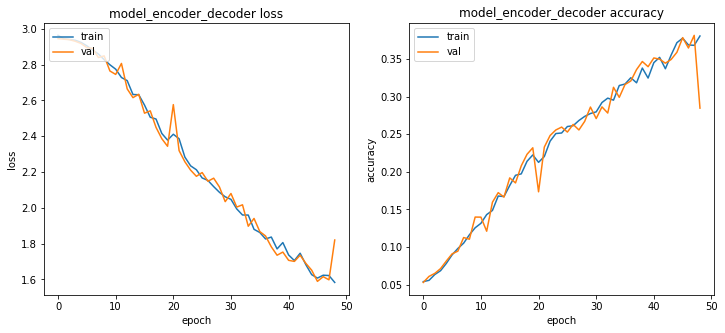

In [15]:
# attention model
attentionLuongGeneral = LuongGeneralAttention(units = 100)
model_attentionLuongGeneral = build_attention_model(attentionLuongGeneral, batch_size, rnn_units)


#training
train_test(model_attentionLuongGeneral, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=50, patience=3)

Epoch 1/50
18/18 [==============================] - 216s 3s/step - loss: 2.9660 - accuracy: 0.0534 - val_loss: 2.9471 - val_accuracy: 0.0520
Epoch 2/50
18/18 [==============================] - 13s 690ms/step - loss: 2.9439 - accuracy: 0.0585 - val_loss: 2.9439 - val_accuracy: 0.0568
Epoch 3/50
18/18 [==============================] - 12s 686ms/step - loss: 2.9386 - accuracy: 0.0640 - val_loss: 2.9331 - val_accuracy: 0.0667
Epoch 4/50
18/18 [==============================] - 12s 687ms/step - loss: 2.9329 - accuracy: 0.0724 - val_loss: 2.9249 - val_accuracy: 0.0840
Epoch 5/50
18/18 [==============================] - 12s 687ms/step - loss: 2.9147 - accuracy: 0.0821 - val_loss: 2.9005 - val_accuracy: 0.0887
Epoch 6/50
18/18 [==============================] - 12s 671ms/step - loss: 2.8901 - accuracy: 0.0943 - val_loss: 2.9023 - val_accuracy: 0.0881
Epoch 7/50
18/18 [==============================] - 12s 672ms/step - loss: 2.8888 - accuracy: 0.0944 - val_loss: 2.8689 - val_accuracy: 0.1021
E

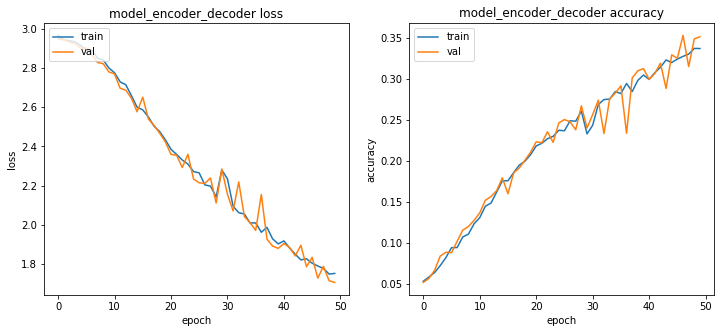

In [14]:
# attention model
attentionLuongGeneralA = LuongGeneralAttention(units = 100)
model_attentionLuongGeneralA, encoder_lstmLuGen, decoder_lstmLuGen, decoder_denseLuGen = build_attention_model(attentionLuongGeneralA, batch_sizeA, rnn_unitsA)


#training
train_test(model_attentionLuongGeneralA, X_trainA, y_trainA , X_testA,
           y_testA, batch_size=batch_sizeA, epochs=50, patience=3)

In [1]:
# attention model
attentionLuongGeneral = LuongGeneralAttention(units = 100)
model_attentionLuongGeneral = build_attention_model(attentionLuongGeneral, batch_size, rnn_units)


#training
train_test(model_attentionLuongGeneral, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=50, patience=5)

NameError: ignored

Esto funciona teniendo:
Dataset formado por 
- n_timesteps_in = 100
- n_features = 20
- batch_size = 100
- rnn_units = 100

**El tema esta en tenir la mateixa rnn_units i batch_size**

# Results

| Attention function  	| Accuracy  	|  Loss 	|   	
|---                  	|---        	|---	    |
| Luong Dot           	| 0.45      	| 0.2     |
| Bahdanau  	          | 0.319  	      | 0.1     |
| Luong General         | 0.331        |  1.7    |

## Visualization the Scores

#### Function to Plot Scores

The idea is take the `build_function` and modify in order to get the `attention_weightPlot` and the `input_seq` and `out_seq`. For do that we need to take into account the following from our model:
* `attention`: the Attention function (LuongDot, LuongGeneral, Bahdanau).
* `encoder_lstm`: encoder used
* `decoder_lstm`: decoder used
* `decoder_dense`: decoder used

In [15]:
 #@title function to Compute and Plot the weight
# function to Compute and Plot the weight

import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K



def build_attention_weight(seq_in, attention, encoder_lstm, decoder_lstm, decoder_dense):
    
    # ENCODER STEP
    # ------------
    # Same encoder as before with one and only difference. Now we need all the lstm states so we
    # set return_sequences=True and return_state=True.
    #encoder_inputs = Input(shape=(n_timesteps_in, n_features), name='encoder_inputs')
    #encoder_lstm = LSTM(rnn_units, return_sequences=True, return_state=True, name='encoder_lstm')
    attention_plot = np.zeros((n_timesteps_in, n_timesteps_in))
    sequence = one_hot_encode(seq_in,n_features)

    encoder_inputs=np.array(sequence).reshape(1,n_timesteps_in,n_features)
    encoder_inputs = tf.convert_to_tensor(encoder_inputs,dtype=tf.float32)

    # Def encoder_lstm
    #encoder_lstm = LSTM(rnn_units, return_sequences=True, return_state=True, name='encoder_lstm') <--------- Usamos los entrenados
    encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
    
    states = [encoder_state_h, encoder_state_c]
    
    # DECODER STEP
    # ------------
    # Set up the decoder layers
    # input shape: (1, n_features + rnn_units)
    #decoder_lstm = LSTM(rnn_units, return_state=True, name='decoder_lstm')        # <--------- Usamos los entrenados
    #decoder_dense = Dense(n_features, activation='softmax', name='decoder_dense') # <--------- Usamos los entrenados
    decoder_input_data = np.zeros((1, 1, n_features))
    decoder_input_data[:, 0, 0] = 1 
    # As before, we use as first input the 0-sequence
    all_outputs = []
    inputs = decoder_input_data
    
    # Decoder_outputs is the last hidden state of the encoder. Encoder_outputs are all the states
    decoder_outputs = encoder_state_h
    
    # Decoder will only process one time step at a time.
    for i in range(n_timesteps_in):

        # Pay attention!
        # decoder_outputs (last hidden state) + encoder_outputs (all hidden states) <---------
        context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
        
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[i] = attention_weights.numpy()
        #context_vector = tf.expand_dims(context_vector, 1) <---------

        decoder_outputs=tf.expand_dims(decoder_outputs, 1)

        context_vector = tf.expand_dims(context_vector, 1)


        # create the context vector by applying attention to 
        # Concatenate the input + context vectore to find the next decoder's input
        inputs = tf.concat([context_vector, inputs], axis=-1)

        # Passing the concatenated vector to the LSTM
        # Run the decoder on one timestep with attended input and previous states
        decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)      
        
        outputs = decoder_dense(decoder_outputs)
        
        # Use the last hidden state for prediction the output
        # save the current prediction
        # we will concatenate all predictions later
        outputs = tf.expand_dims(outputs, 1)
        all_outputs.append(outputs)
        
        # Reinject the output (prediction) as inputs for the next loop iteration
        # as well as update the states
        inputs = outputs
        states = [state_h, state_c]
        
    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    seq_out=one_hot_decode(decoder_outputs[0])  # <---------

    
    #model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')  <---------
    #model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) <---------
    
    return seq_in, seq_out, attention_plot

### Plot attention score weight function

In [16]:
from matplotlib import ticker
import seaborn as sns

def plot_attention(attention, sequence, predicted_sequence, weight_n = True):
  """ 
  attention: the attention function used to calc the weight
  if weight_n = True the weight number will appears, else not.
  """
  fig = plt.figure(figsize=(8,8))
  ax = fig.add_subplot(1, 1, 1)
  ax = sns.heatmap(attention, annot=weight_n, \
                     fmt='.2g', cmap='gist_gray')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sequence, fontdict=fontdict, rotation=45)
  ax.set_yticklabels([''] + predicted_sequence, rotation = 45, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()


def plotWeight(seq_in, attention, encoder_lstm, decoder_lstm, decoder_dense, weight_n = True):
  seq_in, seq_out, attention_plot = build_attention_weight(seq_in, attention, encoder_lstm, decoder_lstm, decoder_dense)

  print('Input: %s' % (seq_in))
  print('Predicted: {}'.format(seq_out))

  attention_plot = attention_plot[:len(seq_out), :len(seq_in)]
  plot_attention(attention_plot, seq_in, seq_out, weight_n)

In [ ]:
# @title build_attention_model function <- with encoders output

import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input, Dense, LSTM, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K

tf.keras.backend.set_floatx('float64')

#attention model
def build_attention_model(attention, batch_size, rnn_units):
    
    # ENCODER STEP
    # ------------
    # Same encoder as before with one and only difference. Now we need all the lstm states so we
    # set return_sequences=True and return_state=True.
    encoder_inputs = Input(shape=(n_timesteps_in, n_features), name='encoder_inputs')
    encoder_lstm = LSTM(rnn_units, return_sequences=True, return_state=True, name='encoder_lstm')
    encoder_outputs, encoder_state_h, encoder_state_c = encoder_lstm(encoder_inputs)
    
    states = [encoder_state_h, encoder_state_c]
    
    # DECODER STEP
    # ------------
    # Set up the decoder layers
    # input shape: (1, n_features + rnn_units)
    decoder_lstm = LSTM(rnn_units, return_state=True, name='decoder_lstm')
    decoder_dense = Dense(n_features, activation='softmax', name='decoder_dense')
    
    # As before, we use as first input the 0-sequence
    all_outputs = []
    inputs = np.zeros((batch_size, 1, n_features))
    
    # Decoder_outputs is the last hidden state of the encoder. Encoder_outputs are all the states
    decoder_outputs = encoder_state_h
    
    # Decoder will only process one time step at a time.
    for _ in range(n_timesteps_in):

        # Pay attention!
        # decoder_outputs (last hidden state) + encoder_outputs (all hidden states)
        context_vector, attention_weights = attention(decoder_outputs, encoder_outputs)
        context_vector = tf.expand_dims(context_vector, 1)

        # create the context vector by applying attention to 
        # Concatenate the input + context vectore to find the next decoder's input
        inputs = tf.concat([context_vector, inputs], axis=-1)

        # Passing the concatenated vector to the LSTM
        # Run the decoder on one timestep with attended input and previous states
        decoder_outputs, state_h, state_c = decoder_lstm(inputs, initial_state=states)        
        outputs = decoder_dense(decoder_outputs)
        
        # Use the last hidden state for prediction the output
        # save the current prediction
        # we will concatenate all predictions later
        outputs = tf.expand_dims(outputs, 1)
        all_outputs.append(outputs)
        
        # Reinject the output (prediction) as inputs for the next loop iteration
        # as well as update the states
        inputs = outputs
        states = [state_h, state_c]
        
    decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)
    model = Model(encoder_inputs, decoder_outputs, name='model_encoder_decoder')
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model, encoder_lstm, decoder_lstm, decoder_dense

### Example dataset:
In order to see propertly the score weight in a heatplot we will use a small dataset reducing the number of times step and number of features.
- n_timesteps_in = 4 
- n_features = 10     
- train_size = 2000 
- test_size = 200

In [17]:
#@title changed part n_timesteps_in, n_features
# dataset 
n_timesteps_in = 4  # Sequence length                                                 ## changed from 100 to 4
n_features = 10     # Maximum number allowed-1 (length of the one-hot-encoded vector) ## changed from 20 to 10
train_size = 2000 
test_size = 200
X_train, y_train, X_test, y_test = create_dataset(train_size, test_size, n_timesteps_in,n_features)

# training parameters
batch_size = 1

# model parameters
rnn_units = 16       # changed from 100 to 16

# Luong Dot Attention

Epoch 1/7
1800/1800 [==============================] - 36s 16ms/step - loss: 1.6820 - accuracy: 0.3515 - val_loss: 1.4339 - val_accuracy: 0.4113
Epoch 2/7
1800/1800 [==============================] - 26s 15ms/step - loss: 1.2968 - accuracy: 0.4700 - val_loss: 1.0922 - val_accuracy: 0.5900
Epoch 3/7
1800/1800 [==============================] - 27s 15ms/step - loss: 0.8861 - accuracy: 0.6660 - val_loss: 0.5981 - val_accuracy: 0.8200
Epoch 4/7
1800/1800 [==============================] - 27s 15ms/step - loss: 0.3573 - accuracy: 0.9225 - val_loss: 0.1693 - val_accuracy: 0.9825
Epoch 5/7
1800/1800 [==============================] - 27s 15ms/step - loss: 0.1168 - accuracy: 0.9893 - val_loss: 0.0833 - val_accuracy: 0.9912
Epoch 6/7
1800/1800 [==============================] - 28s 15ms/step - loss: 0.0626 - accuracy: 0.9942 - val_loss: 0.0728 - val_accuracy: 0.9888
Epoch 7/7
200/200 [==============================] - 2s 8ms/step - loss: 0.0406 - accuracy: 0.9950

PREDICTION ACCURACY (%):
Train

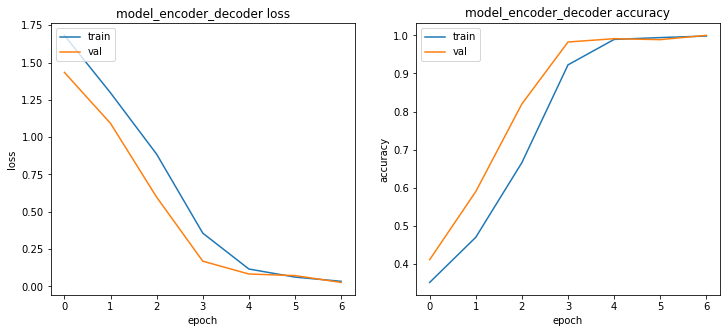

In [18]:
# attention model
attention = LuongDotAttention()
model_attention, encoder_lstm, decoder_lstm, decoder_dense  = build_attention_model(attention, batch_size, rnn_units) 
# we need this encoder/decoder for the weight representation

train_test(model_attention, X_train, y_train , X_test,
           y_test, batch_size=batch_size,epochs=7, patience=3)

Input: [1, 2, 3, 4]
Predicted: [4, 3, 2, 1]


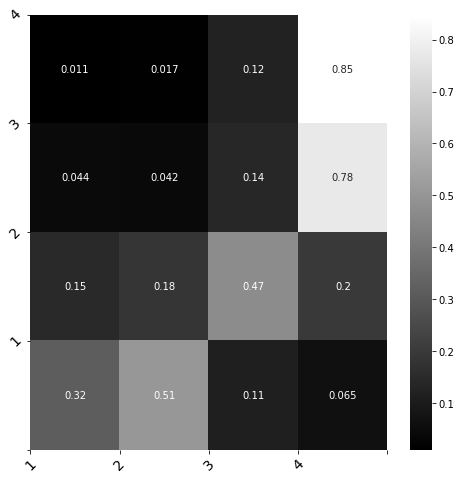

In [19]:
plotWeight([1,2,3,4], attention, encoder_lstm, decoder_lstm, decoder_dense)

Input: [9, 2, 3, 9]
Predicted: [9, 3, 2, 9]


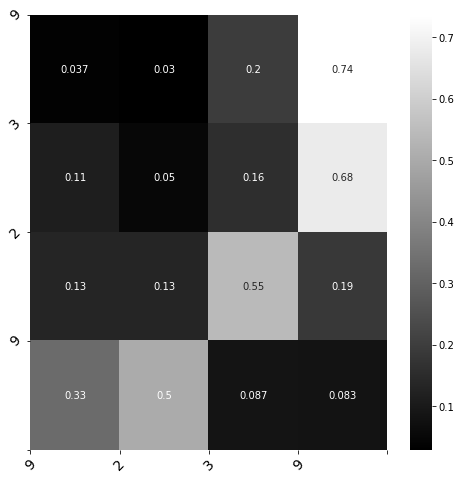

In [20]:
plotWeight([9,2,3,9], attention, encoder_lstm, decoder_lstm, decoder_dense)

# Banhdanau Attention

Epoch 1/7
1800/1800 [==============================] - 41s 18ms/step - loss: 1.6272 - accuracy: 0.3685 - val_loss: 1.3580 - val_accuracy: 0.4163
Epoch 2/7
1800/1800 [==============================] - 29s 16ms/step - loss: 1.1956 - accuracy: 0.4850 - val_loss: 0.9498 - val_accuracy: 0.6238
Epoch 3/7
1800/1800 [==============================] - 29s 16ms/step - loss: 0.3712 - accuracy: 0.9058 - val_loss: 0.0565 - val_accuracy: 1.0000
Epoch 4/7
1800/1800 [==============================] - 28s 16ms/step - loss: 0.0335 - accuracy: 0.9990 - val_loss: 0.0143 - val_accuracy: 1.0000
Epoch 5/7
1800/1800 [==============================] - 30s 16ms/step - loss: 0.0286 - accuracy: 0.9950 - val_loss: 0.0133 - val_accuracy: 1.0000
Epoch 6/7
1800/1800 [==============================] - 30s 17ms/step - loss: 0.0069 - accuracy: 1.0000 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 7/7
200/200 [==============================] - 2s 8ms/step - loss: 0.0018 - accuracy: 1.0000

PREDICTION ACCURACY (%):
Train

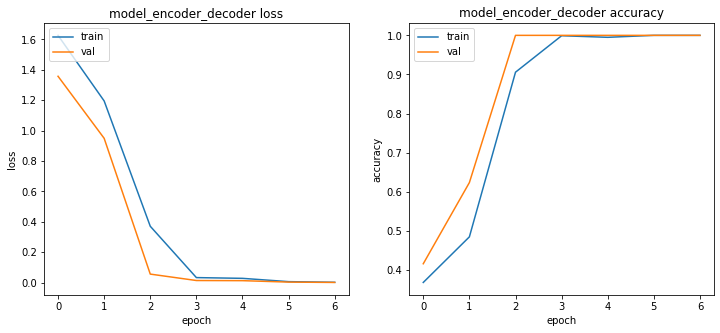

In [21]:
# attention model
attentionBahdanauAttention = BahdanauAttention(16)
model_attentionBahdanauAttention, encoder_lstmBah, decoder_lstmBah, decoder_denseBah = build_attention_model(attentionBahdanauAttention, batch_size, rnn_units)

train_test(model_attentionBahdanauAttention, X_train, y_train , X_test,
           y_test, batch_size=batch_size,epochs=7, patience=3)

Input: [1, 2, 3, 4]
Predicted: [4, 3, 2, 1]


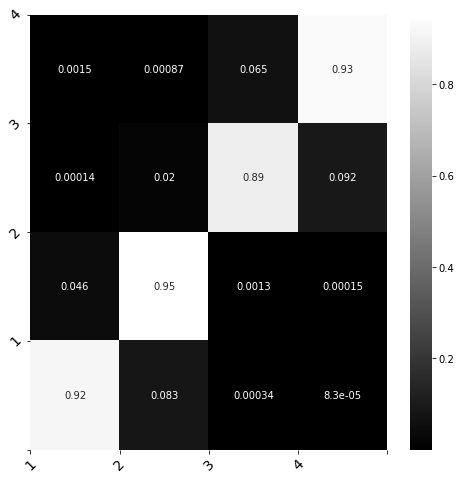

In [22]:
plotWeight([1,2,3,4], attentionBahdanauAttention, encoder_lstmBah, decoder_lstmBah, decoder_denseBah)

Input: [9, 2, 3, 9]
Predicted: [9, 3, 2, 9]


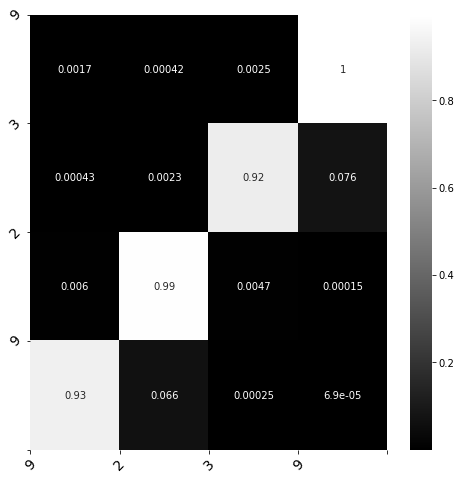

In [23]:
plotWeight([9,2,3,9], attentionBahdanauAttention, encoder_lstmBah, decoder_lstmBah, decoder_denseBah)

# Luong General Attention

Epoch 1/7
1800/1800 [==============================] - 38s 17ms/step - loss: 1.6548 - accuracy: 0.3614 - val_loss: 1.3427 - val_accuracy: 0.4138
Epoch 2/7
1800/1800 [==============================] - 27s 15ms/step - loss: 1.1807 - accuracy: 0.4840 - val_loss: 1.0061 - val_accuracy: 0.5725
Epoch 3/7
1800/1800 [==============================] - 27s 15ms/step - loss: 0.5701 - accuracy: 0.8289 - val_loss: 0.1568 - val_accuracy: 0.9888
Epoch 4/7
1800/1800 [==============================] - 27s 15ms/step - loss: 0.0562 - accuracy: 0.9990 - val_loss: 0.0219 - val_accuracy: 1.0000
Epoch 5/7
1800/1800 [==============================] - 26s 15ms/step - loss: 0.0119 - accuracy: 1.0000 - val_loss: 0.0122 - val_accuracy: 0.9988
Epoch 6/7
1800/1800 [==============================] - 27s 15ms/step - loss: 0.0062 - accuracy: 0.9996 - val_loss: 0.0028 - val_accuracy: 1.0000
Epoch 7/7
200/200 [==============================] - 1s 7ms/step - loss: 0.0011 - accuracy: 1.0000

PREDICTION ACCURACY (%):
Train

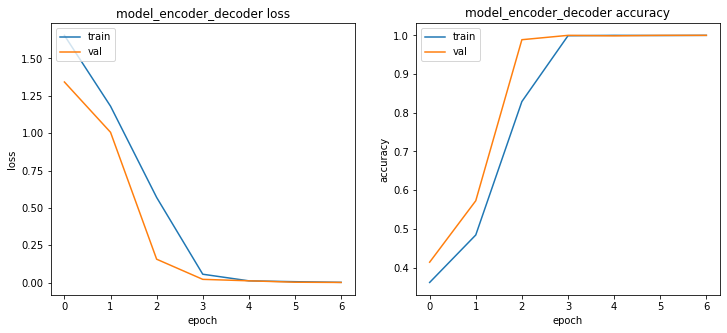

In [24]:
# attention model
attentionLuongGeneral = LuongGeneralAttention(units = 4)
model_attentionLuongGeneral, encoder_lstmLuGen, decoder_lstmLuGen, decoder_denseLuGen = build_attention_model(attentionLuongGeneral, batch_size, rnn_units)


#training
train_test(model_attentionLuongGeneral, X_train, y_train , X_test,
           y_test, batch_size=batch_size, epochs=7, patience=3)

Input: [1, 2, 3, 4]
Predicted: [4, 3, 2, 1]


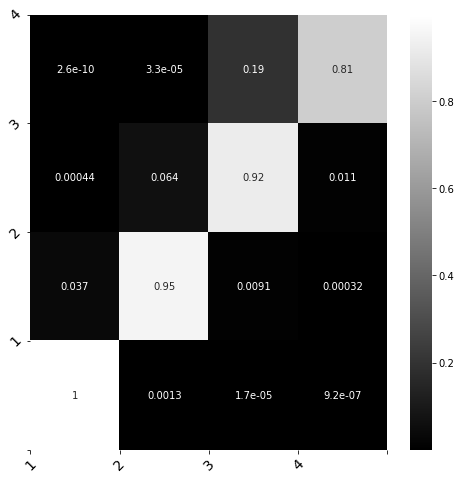

In [25]:
plotWeight([1,2,3,4], attentionLuongGeneral, encoder_lstmLuGen, decoder_lstmLuGen, decoder_denseLuGen)

Input: [9, 2, 3, 9]
Predicted: [9, 3, 2, 9]


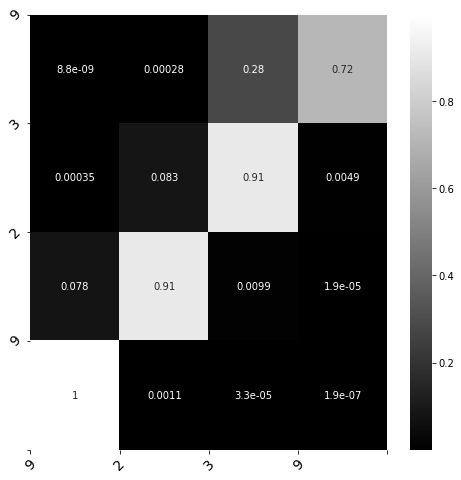

In [26]:
plotWeight([9,2,3,9], attentionLuongGeneral, encoder_lstmLuGen, decoder_lstmLuGen, decoder_denseLuGen)